In [1]:
import os
import numpy as np
import pandas as pd
import dask
import dask.array as da
import dask.dataframe as dd

from holoviews.operation.datashader import datashade
import hvplot.dask
import hvplot.pandas

import mplhep as hep

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
from dask.distributed import Client, LocalCluster

#cluster = LocalCluster(n_workers=10, 
#                       threads_per_worker=1,
#                       memory_limit='6Gb')
#client = Client(cluster)

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(scheduler_file='/global/cscratch1/sd/cwalter/dask-mpi/scheduler.json')

client

<Client: 'tcp://10.128.0.111:37515' processes=7 threads=7, memory=110.86 GB>

In [4]:
scratch= os.environ["SCRATCH"]

#selected=['id', 'mag_r', 'g1', 'g2', 'e1','e2']
selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

#df = pd.read_parquet('shear-matched.parquet')#.dropna()
#df = dd.read_parquet(f'{scratch}/parquet-cosmoDC2/shear-cosmoDC2-*.parquet', columns=selected)
#df = dd.read_parquet(f'{scratch}/parquet-skysim-small/*.parquet', columns=selected, engine='pyarrow')
#df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
df = dd.read_parquet(f'{scratch}/skysim-sampled', columns=selected, engine='pyarrow')
df = df.persist()

print('Columns:', df.columns.values, '#Rows:', df.z.size.compute()/1e9)

Columns: ['id' 'mag_r' 'z' 'ra' 'dec' 'g1' 'g2'] #Rows: 0.0626302


In [5]:
%%script false

scratch= os.environ["SCRATCH"]

selected=['galaxy_id', 'mag_r', 'redshift_true', 'ra', 'dec', 'shear_1', 'shear_2']
rename_map ={'galaxy_id':'id', 'mag_r':'mag_r', 'redshift_true':'z', 'ra':'ra', 'dec':'dec', 'shear_1':'g1', 'shear_2':'g2'}

df = dd.read_parquet(f'/global/cfs/cdirs/lsst/shared/xgal/cosmoDC2/cosmoDC2_v1.1.4_parquet/*',columns=selected, engine='pyarrow')
df = df.rename(columns=rename_map)
df = df.query('mag_r < 29')
print('Columns:', df.columns.values, '#Rows:', df.ra.size.compute()/1e9)

In [6]:
print(f'g1 mean = {df.g1.mean().compute():.6f}')
print(f'g2 mean = {df.g2.mean().compute():.6f}')

g1 mean = 0.000451
g2 mean = -0.000043


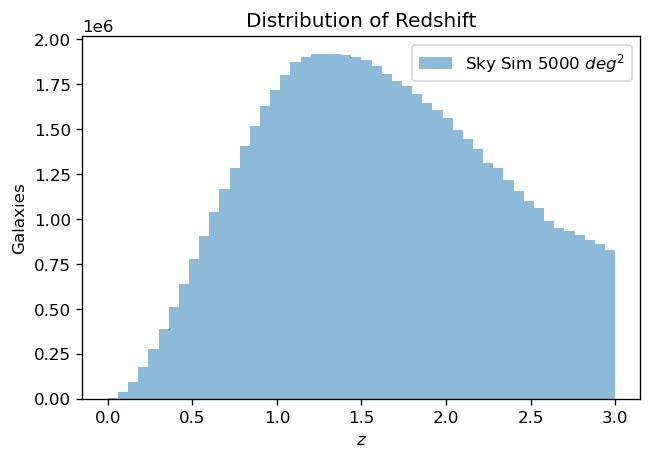

In [7]:
h, bins = da.histogram(df.z, bins=50, range=[0, 3])
values = h.compute();

hep.histplot(values, bins, histtype='fill', alpha=0.5, label=r'Sky Sim 5000 $deg^2$')
plt.title('Distribution of Redshift')
plt.xlabel(r'$z$')
plt.ylabel(r'Galaxies');
plt.legend()

In [8]:
from collections import namedtuple
import scipy.stats

Binned = namedtuple('Binned','count statistic statistic2 bin_edges')

def dask_binned_statistic(df, x_variable, y_variable, function, bins, range):
    
    df_x = df.filter([x_variable]).squeeze()
    df_y = df.filter([y_variable]).squeeze()
    
    binned = scipy.stats.binned_statistic(df_x, values=[np.isfinite(df_y), df_y, df_y*2], statistic=function, bins=bins, range=range)
    return Binned(binned.statistic[0], binned.statistic[1], binned.statistic[2], binned.bin_edges)

def profile_1d(dataframe, x_variable, y_variable, bins, limits):

    sum_array = dataframe.map_partitions(dask_binned_statistic, x_variable, y_variable, 'sum', bins, range=limits).compute()

    bin_edges = sum_array[0].bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    count =  np.array([sum.count for sum in sum_array]).sum(axis=0)
    summed = np.array([sum.statistic for sum in sum_array]).sum(axis=0)
    summed2= np.array([sum.statistic2 for sum in sum_array]).sum(axis=0)

    mean = summed/count
    mean2 = summed2/count
    error = np.sqrt(mean2 - mean**2)/np.sqrt(count)
    
    return bin_centers, mean, error

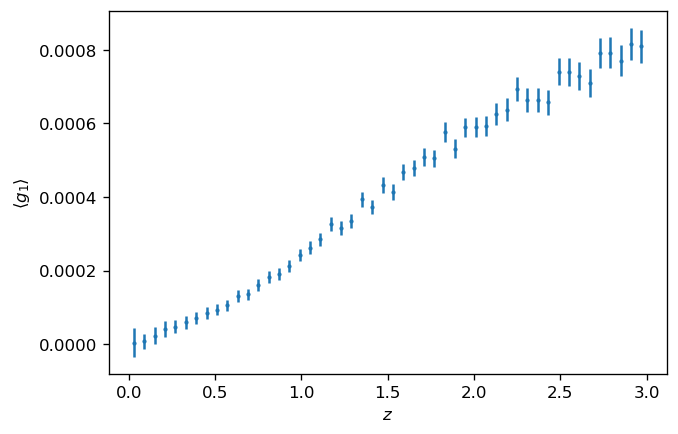

In [9]:
bin_centers, mean, error = profile_1d(df, 'z', 'g1', 50, [0.0, 3.0])
plt.errorbar(x=bin_centers, y=mean, yerr=error, fmt = '.', markersize=3)
#plt.ylim(bottom=0)
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_1 \rangle$');

/global/homes/c/cwalter/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


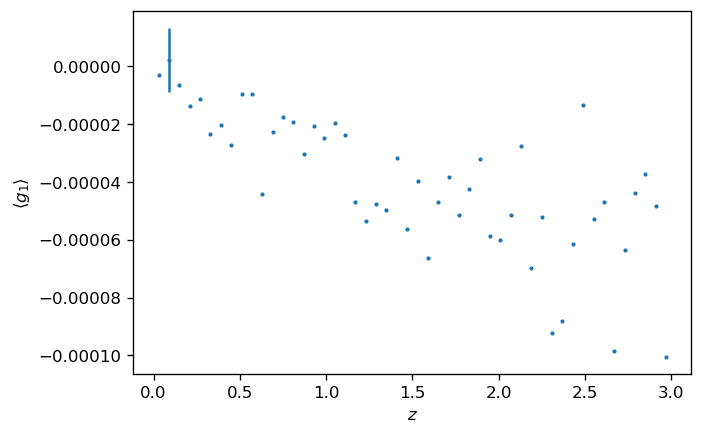

In [10]:
bin_centers, mean, error = profile_1d(df, 'z', 'g2', 50, [0.0, 3.0])
plt.errorbar(x=bin_centers, y=mean, yerr=error, fmt = '.', markersize=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_1 \rangle$');

Text(0, 0.5, '$\\langle g_1 \\rangle$')

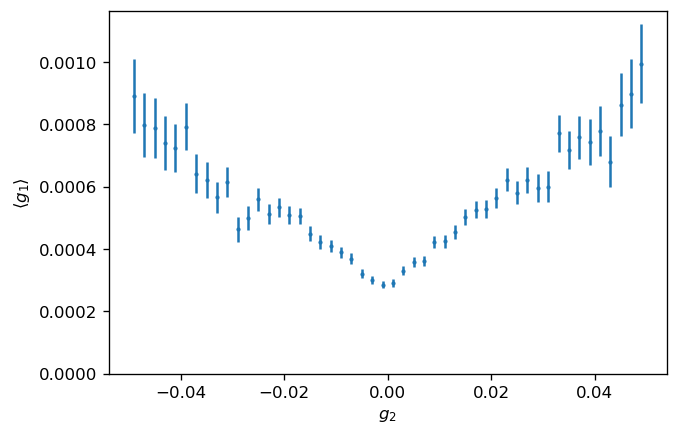

In [11]:
bin_centers, mean, error = profile_1d(df, 'g2', 'g1', 50, [-.05, .05])
plt.errorbar(x=bin_centers, y=mean, yerr=error, fmt = '.', markersize=3)
plt.ylim(bottom=0)
plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g_1 \rangle$')

/global/homes/c/cwalter/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


Text(0, 0.5, '$\\langle g^{\\prime}_1 \\rangle$')

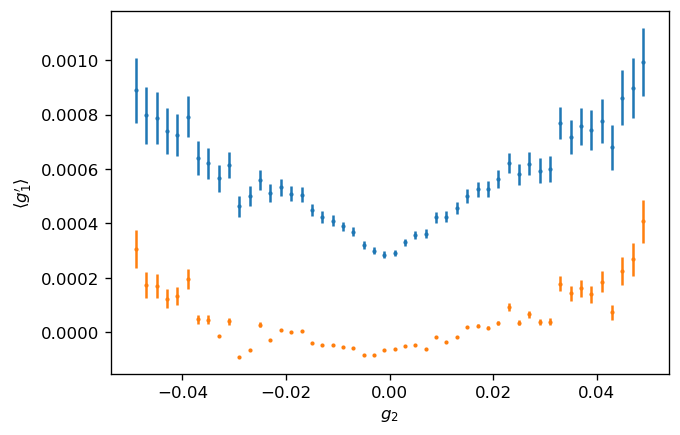

In [12]:
slope_g1 = .00085/3 # <g1>/z
slope_g2 = -7e-5/3 # <g2>/z

df['g1_prime'] = df.g1 - slope_g1*df.z
df['g2_prime'] = df.g2 - slope_g2*df.z

bin_centers_prime, mean_prime, error_prime = profile_1d(df, 'g2_prime', 'g1_prime', 50, [-.05, .05])

plt.errorbar(x=bin_centers, y=mean, yerr=error, fmt = '.', markersize=3)
plt.errorbar(x=bin_centers, y=mean_prime, yerr=error_prime, fmt = '.', markersize=3)
plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g^{\prime}_1 \rangle$')

In [13]:
df.hvplot.scatter('ra','dec', datashade=True)

:DynamicMap   []
   :RGB   [ra,dec]   (R,G,B,A)

In [14]:
num_bins = 50

#x_range = np.linspace(45, 80, num_bins)
#y_range = np.linspace(-45, -24, num_bins)

x_range = np.linspace(-.04, .04, num_bins)
y_range = np.linspace(-.04, .04, num_bins)

df['x'] = df.g1.map_partitions(pd.cut, bins=x_range, labels=y_range[:-1])
df['y'] = df.g2.map_partitions(pd.cut, bins=y_range, labels=x_range[:-1])

grouped = df.groupby(['x', 'y']).g1.count().compute()
map = grouped.unstack()
map.hvplot.heatmap(y='index', x='columns', width=800, height=500, rot =70, xformatter='%0.3f', logz=True)

:HeatMap   [columns,index]   (value)

In [15]:
Binned_2d = namedtuple('Binned','count statistic statistic2 x_edge y_edge')

def dask_binned_statistic_2d(df, function, bins, limits):
    
    binned = scipy.stats.binned_statistic_2d(x=df.ra, y=df.dec, values=[np.isfinite(df.id), df.g1, df.g1**2], 
                                             statistic=function, bins=bins, range=limits)
    return Binned_2d(binned.statistic[0], binned.statistic[1], binned.statistic[2], binned.x_edge, binned.y_edge)

#limits = [[48, 76], [-47, -24]]
limits = [[0, 90], [-88, 0]]
sum_array_2d= df.map_partitions(dask_binned_statistic_2d, 'sum', 3, limits).compute()

count_2d =  np.array([sum.count for sum in sum_array_2d]).sum(axis=0)
summed_2d = np.array([sum.statistic for sum in sum_array_2d]).sum(axis=0)
summed2_2d = np.array([sum.statistic2 for sum in sum_array_2d]).sum(axis=0)

x_edges = sum_array_2d[0].x_edge
y_edges = sum_array_2d[0].y_edge

x_centers = (x_edges[:-1] + x_edges[1:])/2.
y_centers = (y_edges[:-1] + y_edges[1:])/2.

mean_2d = summed_2d/count_2d

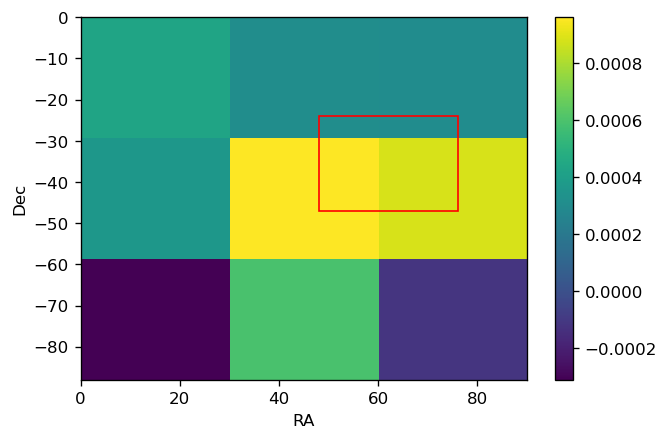

In [16]:
import matplotlib.patches as patches

#plt.imshow(mean_2d.T, origin='lower', extent=[48, 76, -47, -24], vmin=0)
plt.imshow(mean_2d.T, origin='lower', extent=[0, 90, -88, 0], aspect='auto')
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

currentAxis = plt.gca()
cosmoDC2 = patches.Rectangle((48,-47),28,23,linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(cosmoDC2)

#hv.Image((x_edges,y_edges,mean_2d) , ['ra', 'dec'], 'Mean').options(tools=['hover'], colorbar=True, width=600, height=500)

In [ ]:
import math 

reduced_shear = mean_2d
magnitude = np.abs(mean_2d)
phi = math.pi/2

currentAxis = plt.gca()
cosmoDC2 = patches.Rectangle((48,-47),28,23,linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(cosmoDC2)

plt.quiver(x_centers, y_centers, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid', width=.00500)
plt.xlabel('RA')
plt.ylabel('Dec')

In [ ]:
#def test_chris(df):
#    
#    return df.g1.sum()

#sum_array = df.map_partitions(test_chris).compute()

In [ ]:
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.dpi'] = 150

selected = df.query('.009 < g2 < 0.011')
selected.g1.size.compute()

selected.g1.hist(bins=10, grid=True, histtype='step')
plt.title('.009 < g2 < 0.011')
plt.yscale('log')
plt.xlabel('g1')

In [4]:
client.restart();

In [26]:
client.cancel(df)